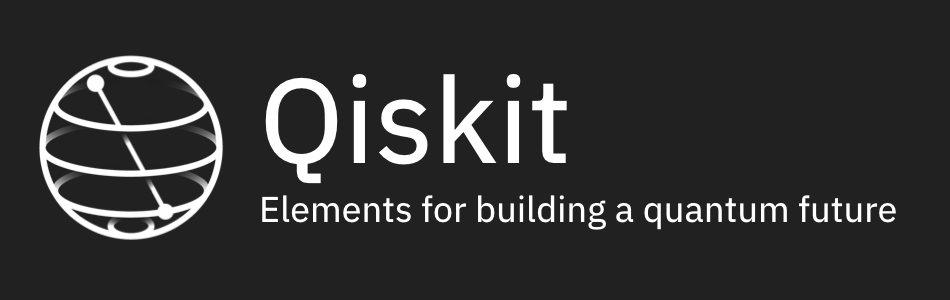

# QasmSimulator: matrix product state simulation method

## Simulation methods
The `QasmSimulator` has several simulation methods including `statevector`, `stabilizer`, `extended_stabilizer` and `matrix_product_state`. Each of these determines the internal representation of the quantum circuit and the algorithms used to process the quantum operations. They each have advantages and disadvantages, and choosing the best method is a matter of investigation.
In this tutorial, we focus on the `matrix product state simulation method`.


## Matrix product state simulation method
This simulation method is based on the concept of `matrix product states`. This structure was initially proposed in the paper *Efficient classical simulation of slightly entangled quantum computations* by Vidal in https://arxiv.org/abs/quant-ph/0301063. There are additional papers that describe the structure in more detail, for example *The density-matrix renormalization group in the age of matrix product states* by Schollwoeck https://arxiv.org/abs/1008.3477.

A pure quantum state is usually described as a state vector, by the expression $|\psi\rangle =  \sum_{i_1=0}^1 {\ldots} \sum_{i_n=0}^1 c_{i_1 \ldots i_n} |i_i\rangle {\otimes} {\ldots} {\otimes} |i_n\rangle$.

The state vector representation implies an exponential size representation, regardless of the actual circuit. Every quantum gate operating on this representation requires exponential time and memory.

The matrix product state (MPS) representation offers a local representation, in the form:
$\Gamma^{[1]} \lambda^{[1]} \Gamma^{[2]} \lambda^{[2]}\ldots \Gamma^{[1]} \lambda^{[n-1]} \Gamma^{[n]}$, such that all the information contained in the $c_{i_1 \ldots i_n}$, can be generated out of the MPS representation.


Every $\Gamma^{[i]}$ is a tensor of complex numbers that represents qubit $i$. Every $\lambda^{[i]}$ is a matrix of real numbers that is used to normalize the amplitudes of qubits $i$ and $i+1$. Single-qubit gates operate only on the relevant tensor. 

Two-qubit gates operate on consecutive qubits $i$ and $i+1$. This involves a tensor-contract operation over $\lambda^{[i-1]}$, $\Gamma^{[i-1]}$, $\lambda^{[i]}$, $\Gamma^{[i+1]}$ and  $\lambda^{[i+1]}$, that creates a single tensor. We apply the gate to this tensor, and then decompose back to the original structure. This operation may increase the size of the respective tensors. Gates that involve two qubits that are not consecutive, require a series of swap gates to bring the two qubits next to each other and then the reverse swaps. 

In the worst case, the tensors may grow exponentially. However, the size of the overall structure remains 'small' for circuits that do not have 'many' two-qubit gates. This allows much more efficient operations in circuits with relatively 'low' entanglement. Characterizing when to use this method over other methods is a subject of current research.

## Using the matrix product state simulation method
The matrix product state simulation method is invoked in the `QasmSimulator` by setting the `simulation_method`. 
Other than that, all operations are controlled by the `QasmSimulator` itself, as in the following example:

In [1]:
import numpy as np

# Import Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.providers.aer import QasmSimulator

# Construct quantum circuit
circ = QuantumCircuit(2, 2)
circ.h(0)
circ.cx(0, 1)
circ.measure([0,1], [0,1])

# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

# Define the simulation method
backend_opts_mps = {"method":"matrix_product_state"}

# Execute and get counts, using the matrix_product_state method
result = execute(circ, simulator, backend_options=backend_opts_mps).result()
counts = result.get_counts(circ)
counts

{'11': 489, '00': 535}

To see the internal state vector of the circuit, we can import the snapshot files:

In [2]:
from qiskit.extensions.simulator import Snapshot
from qiskit.extensions.simulator.snapshot import snapshot

In [3]:
circ = QuantumCircuit(2, 2)
circ.h(0)
circ.cx(0, 1)

# Define a snapshot that shows the current state vector
circ.snapshot('my_sv', snapshot_type='statevector')
circ.measure([0,1], [0,1])

# Execute
job_sim = execute([circ], QasmSimulator(), backend_options=backend_opts_mps)
result = job_sim.result()
res = result.results

#print the state vector
statevector = res[0].data.snapshots.statevector
statevector['my_sv']

[[[0.7071067811865475, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.7071067811865475, 0.0]]]

In [4]:
result.get_counts()

{'11': 517, '00': 507}

Running circuits using the matrix product state simulation method can be fast, relative to other methods. However, if we generate the state vector during the execution, then the conversion to state vector is, of course, exponential in memory and time, and therefore we don't benefit from using this method. We can benefit if we only do operations that don't require printing the full state vector. For example, if we run a circuit and then take measurement. The circuit below has 200 qubits. We create an `EPR state` involving all these qubits. Although this state is highly entangled, it is handled well by the matrix product state method, because there are effectively only two states. 

We can handle more qubits than this, but execution may take a few minutes. Try running a similar circuit with 500 qubits! Or maybe even 1000 (you can get a cup of coffee while waiting).

In [6]:
num_qubits = 50
qr = QuantumRegister(num_qubits)
cr = ClassicalRegister(num_qubits)
circ = QuantumCircuit(qr, cr)

# Create EPR state
circ.h(qr[0])
for i in range (0,num_qubits-1):
    circ.cx(qr[i], qr[i+1])

# Measure
circ.measure(qr, cr)

job_sim = execute([circ], QasmSimulator(), backend_options=backend_opts_mps)
result = job_sim.result()
print("Time taken: {} sec".format(result.time_taken))
result.get_counts()

Time taken: 1.5781288146972656 sec


{'00000000000000000000000000000000000000000000000000': 496,
 '11111111111111111111111111111111111111111111111111': 528}

In [7]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright